#**Print Privacy**
##**Training Neural Nets on GAN-Generated Handwriting**
by Ciaran Lowell



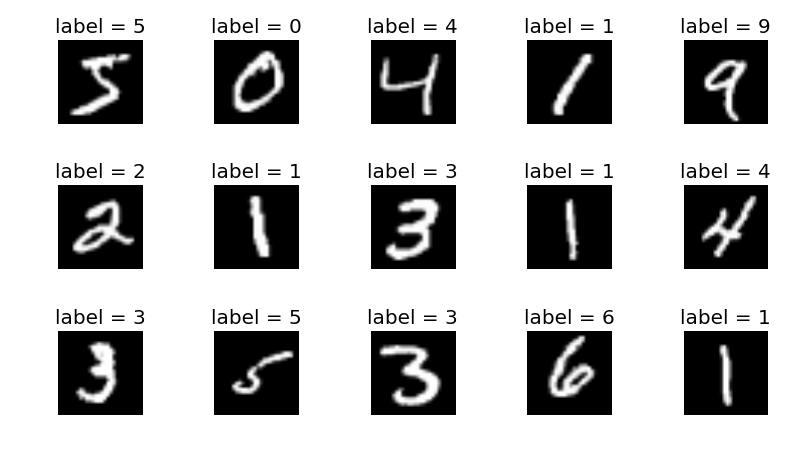

Sample MNIST data

## **Data Privacy and Machine Learning**

Machine learning has exploded in the 21st century. Data scientists now have access to unprecedented computing power, as well as massive datasets derived from technology and the internet. Models trained on these huge datasets are capable of amazing feats of prediction and classification.

However, this era of "Big Data" is not without problems. Technology is inescapable, and many people have growing concerns about privacy. Neural Networks and other cutting-edge machine learning tools require massive amounts of data to train. Increasingly, people are uncomfortable having their data publicly available online as part of these datasets, and with good reason. 

A popular computer vision application in times of COVID has been models that identify if people are wearing masks correctly. These models require massive datasets of human faces to train- and many subjects might not be comfortable having datasets of their face freely available online and used to train algorithms of unknown purpose. The same GAN concept that will be shown in this paper could be used to generate artificial face datasets, limiting the amount of real face images that would need to be made publicly available for training.

[In this stunning New York Times article](https://www.nytimes.com/interactive/2019/12/19/opinion/location-tracking-cell-phone.html), reporters accessing publicly-available phone location datasets were able to identify specific individuals, and trace their private comings-and-goings. As "Big Data" continues to expand and technology monitors more parts of our lives, Machine Learning researchers will need to be cognizant of privacy.

**Could we use Machine Learning to find a solution for these privacy concerns?**


## **Computer Vision and Handwriting- *With a Twist***

One of the most common Computer Vision applications is writing code to read hand-written numbers. This use-case is vital in a wide range of industries, including banking, mail systems, and digitizing documents. Reading handwritten numbers is considered a solved computer vision process. Modern classifiers have an extremely high rate of success reading handwritten numbers, and the application is used as a method of benchmarking new computer vision algorithms.

However, we'll use this handwriting data as a proof-of-concept for a process that could be applied to more relevant datasets. 

This project will create a Neural Nets to analyze handwriting images- **but the model will never see real human handwriting**

Instead, I'll create an **Auxillary Categorical Generative Adversarial Network (AC-GAN),** which will learn to synthesize convincing fascimiles of human handwriting. These artificially-created images will be used to train a Neural Net, which will then be tested on images of handwriting seen by neither the AC-GAN or the Neural Net model.

##**MNIST Dataset**

A popular dataset for training handwriting analysis networks and for benchmarking new classifiers is the MNIST dataset. The MNIST dataset consists of 70,000 images of handwritten digits, split into 60,000 training images and 10,000 testing images. More information about this dataset, including statistics of common neural networks fit on the data, is available at [this link](http://yann.lecun.com/exdb/mnist/)

##**Process**

First, I'll take a basic look at the MNIST images, and the distribution of digits within the dataset.

Next, I'll fit a Generative Adversarial Network on the MNIST data. This network will become  effective at generating convincing examples of human handwriting. I'll use this GAN to generate 1600 hundreds examples of each digit from 0-9.

Then, I'll train a simple neural net of my own creation,. **This network will learn to read handwritten numbers, without *ever* seeing examples of real human handwriting.**

Finally, we'll use the network fit on the GAN data to analyze previously unseen handwriting samples I took from myself and my family. Neither the GAN or the Neural Network will see any of this data before they are tested on it. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image    
import numpy as np
import keras
import math
from math import sqrt
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.models import Sequential


In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

## Preliminary Data Visualization

The MNIST dataset consists of 70,000 grayscale images, in a 28 x 28 pixel size. The "label" column denotes which number is represented by that image. Each other column corresponds to a pixel within the image, where the cell value corresponds to a darkness value between 0 and 255. This results in a total of 784 pixels for each image. The default dataset images have a black background and white digits- I invert the color for easier human viewing, and to more closely resemble actual handwriting examples.

The data is split into a 60,000 observation Training set and a 10,000 observation Test set.

Both the training and testing sets represent roughly equivalent numbers of images for each digit. "1" is slightly overrepresented, while "5" is slightly underrepresented.

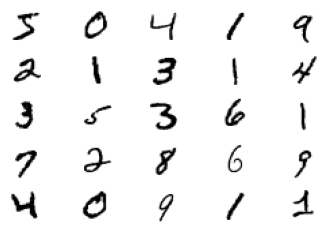

In [10]:
# load the images into memory
# plot images from the training dataset
images = []
for i in range(25):
  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pixels = x_train[i]
  pixels = np.array(pixels, dtype='uint8')
  pixels = pixels.reshape((28, 28)) 
  image = Image.fromarray(pixels)
  images.append(image)
  pyplot.imshow(images[i], cmap='gray_r')
pyplot.show()

Text(0, 0.5, 'Count')

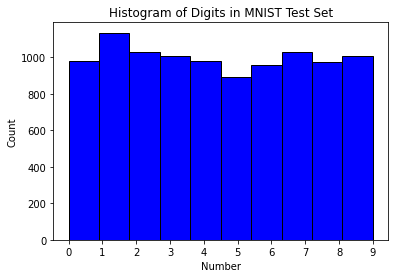

In [15]:
x=[0,1,2,3,4,5,6,7,8,9]
plt.hist(y_test, color = 'blue', edgecolor = 'black')
plt.xticks(x)
plt.title('Histogram of Digits in MNIST Test Set')
plt.xlabel('Number')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

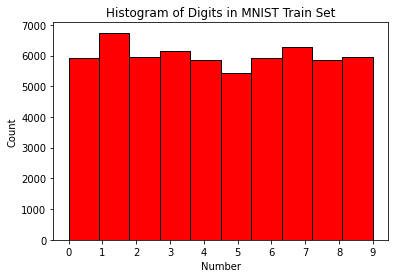

In [16]:
x=[0,1,2,3,4,5,6,7,8,9]
plt.hist(y_train, color = 'red', edgecolor = 'black')
plt.xticks(x)
plt.title('Histogram of Digits in MNIST Train Set')
plt.xlabel('Number')
plt.ylabel('Count')

##**Auxiliary Classifier Generative Adversarial Network (AC-GAN)**

First, we'll create an Auxiliary Classifier GAN, which will be trained on the MNIST dataset. Then, we'll use this GAN to create artificial data to train our other models.

###**How does a GAN work?**

The Generative Adversarial Network is composed of two neural networks that are working against each other. The **Generator network** takes in images from the MNIST dataset, and attempts to create images that resemble the original MNIST classes. The **Discriminator network** is passed a mix of real and artificial MNIST images, and must discriminate between the real and fake images. As these models run thousands of iterations, they become increasingly effective at generating realistic MNIST data.

For this dataset, I use a slightly modified version of a GAN called an Auxiliary Classifier GAN. In this implementation, the Generator network can be set to output images of a specific class, such as 1 or 7. The Discriminator network not only tells the difference between real or fake images, but also must classify each image. This implementation will help generate artificial data for each class, and also trains a powerful classifier that could later be used to classify other handwriting images.

###**How does this help protect privacy?**

This GAN implementation could be extremely useful for training models on sensitive privacy data. A trusted group of researchers with access to sensitive data could create this AC-GAN and use it to generate data to be shared with other researchers. Instead of passing around datasets containing the information of real people, datasets could be constructed of entirely artificial data that is not tied to any person. This process can create extremely complex artificial data that is suitable for training models, and minimizes privacy concerns by restricting the number of people who have access to the original confidential data. 

This project uses [Jason Brownlee's keras GAN implementation](https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/), adapted to the MNIST digits dataset instead of the Clothing database he uses. 



### Discriminator Model

The discriminator model is one half of the GAN, the half that sorts real from fake images. In this implementation, it also classifies the images as which digit it represents (0-9). This dual purpose explains the model's unusual double-pronged output layers.

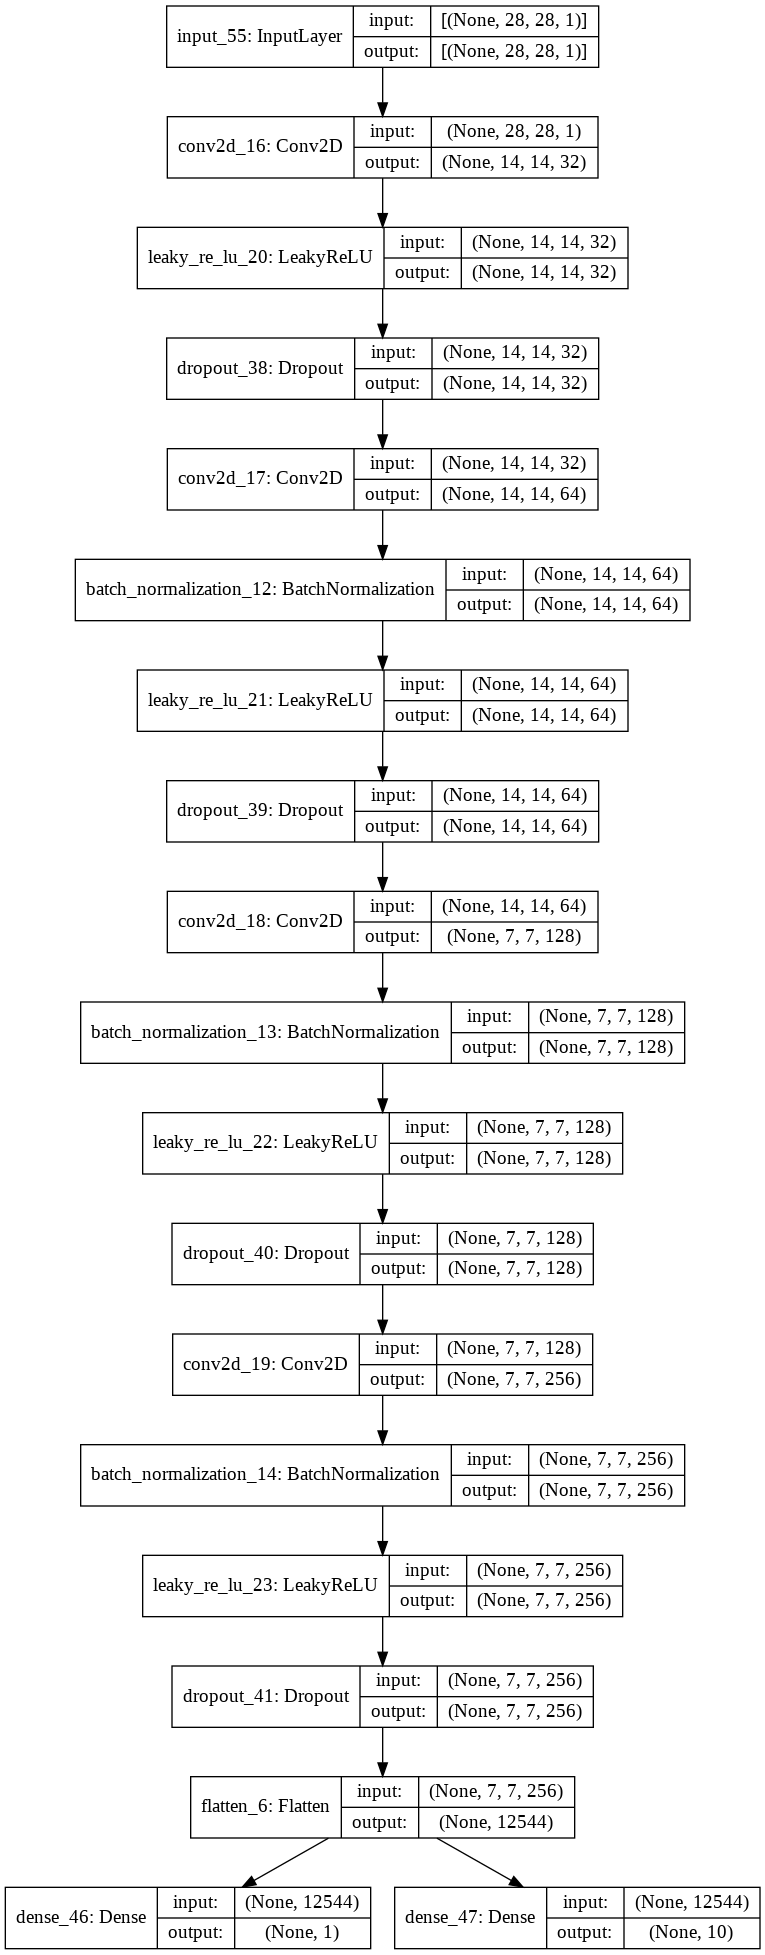

In [99]:

def define_discriminator(in_shape=(28,28,1), n_classes=10):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=in_shape)
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Flatten()(fe)
	out1 = Dense(1, activation='sigmoid')(fe)
	out2 = Dense(n_classes, activation='softmax')(fe)
	model = Model(in_image, [out1, out2])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model
 
model = define_discriminator()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### Generator Model

The Generator half of the GAN attempts to create images that will fool the Discriminator model. As part of this process, the Generator model will learn how to make convincing fascimiles of each digit class from the MNIST dataset. It's output shape is 28x28x1, the same as the 28 pixel grayscale images from MNIST. 

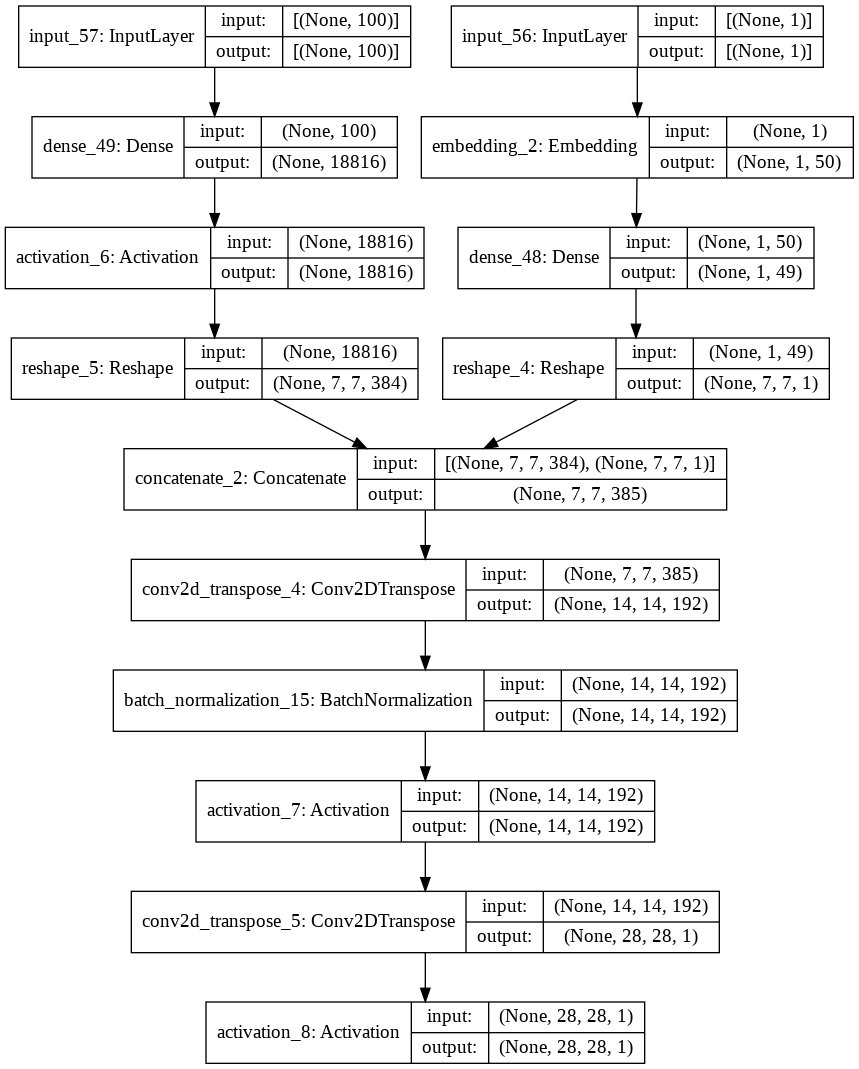

In [100]:
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model
 
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [101]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model
 
# load and preprocess images
def load_real_samples():
	# expand to 3d, e.g. add channels dimension
	# convert from unsigned ints to floats
  X = expand_dims(x_train, axis=-1)
  X = X.astype('float32')
	# scale from [0,255] to [0,1]
  X = (X - 127.5) / 127.5
  #print(X.shape, trainy.shape)
  return [X, y_train]
 
# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  #print(ix)
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [103]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
  # prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	#print('>Saved: %s and %s' % (filename1, filename2))
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
	# calculate the number of batches per training epoch
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
  n_steps = 8000
	# calculate the size of half a batch of samples
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  for i in range(n_steps):
		# get randomly selected 'real' samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
    _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
    _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
	
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples, n_class):
	# plot images
  for i in range(n_examples):
		# define subplot
    #pyplot.subplot(math.sqrt(n_examples), math.sqrt(n_examples), 1 + i)
		# turn off axis
    pyplot.axis('off')
    filepath = str("./artificialDigits/" + str(n_class) + '/'+ str(i) + '.png')
		# plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.savefig(fname = filepath,bbox_inches = 'tight', dpi = 50)
    #pyplot.show()


## **Creating Artificial Dataset**

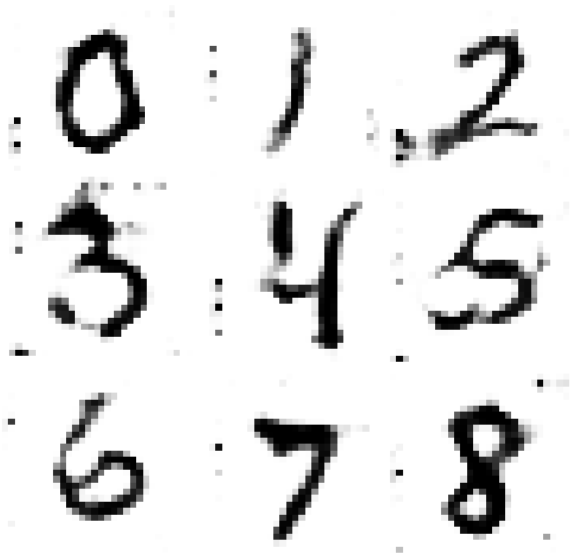

*Image: Examples of artificial handwritten digits generated by the GAN*

Now that our GAN has been trained, we can use the Generator function to populate an artificial dataset.

Unfortunately, due to computational restrictions, I was only able to train the GAN on about 4000 epochs. Ideally, the models would run for almost 100,000 epochs, and learn to create very convincing numerals.

As it is, the artificial dataset is mostly recognizable, but the generator struggled with some similar numbers such as 5 and 6.

Again, computational restrictions will limit the scope of my analysis. Ideally, I would like to create around 6000 images for each class- matching the 60,000 images in the original MNIST training set. 

Due to storage and computational limits, I only create 225 images for each class. 

In [ ]:
count = 0
count2 = 0
artificialX = {}
artificialy = []
while count < 10:
  model = generator
  latent_dim = 100
  n_examples = 225
  n_class = count 
  # generate images
  latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
  # generate images
  X  = model.predict([latent_points, labels])
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  save_plot(X, n_examples, count)
  print(count)
  count = count+1
 

## Generic Model

Now that I've created my artificial dataset, I want to train a neural net on the computer-generated images.

This neural net is a very simple Sequential model I built in Keras. It's a typical computer vision neural net that alternates Conv2D Relu layers with Maxpooling layers. I added several Dropout and Batch Normalization layers to try and reduce overfitting that might result from our small dataset.  

In [225]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(keras.layers.GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.7))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
            
model.compile(loss='categorical_crossentropy',
                    optimizer='nadam',
                    metrics=['categorical_accuracy'])
# plot the model
model.summary()                                         

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_291 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_292 (Conv2D)          (None, 13, 13, 32)        9248      
_________________________________________________________________
batch_normalization_334 (Bat (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_231 (Dropout)        (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_293 (Conv2D)          (None, 4, 4, 64)        

Now that we've built the model, let's fit it on the fake images and see how successful it is.

After 50 epochs, even this simple model achieves a categorical accuracy of 97% on the computer-generated validation data. 

In [226]:
dataGenerator = keras.preprocessing.image.ImageDataGenerator(validation_split = .2, samplewise_std_normalization= True, fill_mode = 'constant', cval = 0)
train = dataGenerator.flow_from_directory("./artificialDigits/", class_mode='categorical', batch_size=32, target_size=(32, 32), subset = 'training', shuffle = True, interpolation = 'nearest')
test = dataGenerator.flow_from_directory("./artificialDigits/",class_mode='categorical', batch_size=32, target_size=(32, 32), subset = 'validation', shuffle = True, interpolation = 'nearest')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100, restore_best_weights = True)
model.fit(train, validation_data = (test), epochs = 50, shuffle = True, callbacks = [es])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1602 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
Epoch 1/50
51/51 [==============================] - 6s 63ms/step - loss: 3.4181 - categorical_accuracy: 0.1088 - val_loss: 2.3345 - val_categorical_accuracy: 0.1725
Epoch 2/50
51/51 [==============================] - 3s 54ms/step - loss: 2.7789 - categorical_accuracy: 0.1949 - val_loss: 2.4646 - val_categorical_accuracy: 0.2050
Epoch 3/50
51/51 [==============================] - 3s 54ms/step - loss: 2.2904 - categorical_accuracy: 0.2802 - val_loss: 2.3804 - val_categorical_accuracy: 0.2825
Epoch 4/50
51/51 [==============================] - 3s 56ms/step - loss: 1.9173 - categorical_accuracy: 0.3835 - val_loss: 2.2378 - val_categorical_accuracy: 0.3375
Epoch 5/50
51/51 [==============================] - 3s 57ms/step - loss: 1.7310 - categorical_accuracy: 0.4313 - val_loss: 1.9609 - val_categorical_accuracy: 0.5000
Epoch 6/50
51/51 [==============================] - 3s 58ms/step - loss: 1.5209 - categori

##Testing on Real, Unseen Data

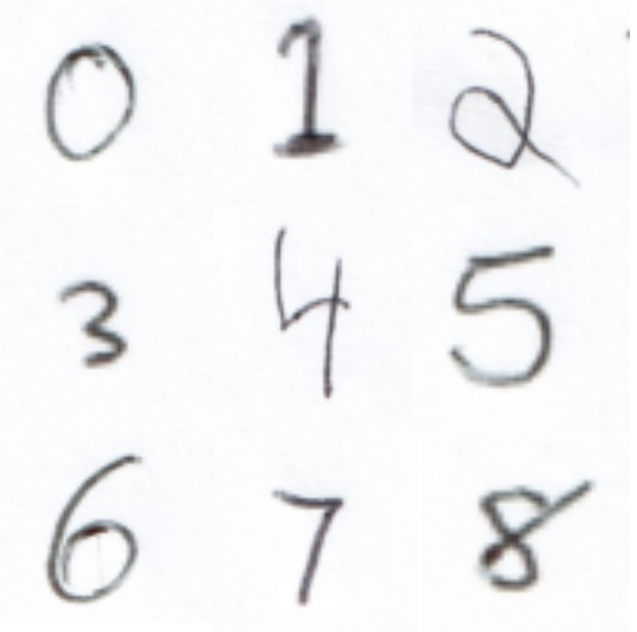

*Image- handwriting samples taken from myself and family*


Unfortunately, my Neural Net is only able to perform at about 50% accuracy when analyzing the real handwriting samples.

This could indicate an inconsistency in the way I created and pre-processed my handwriting samples, or it could be a result of the computational limits I had to impose on the GAN and the size of the generated dataset. 

Though the results of my experiment were lackluster, I hope you enjoyed reading about them as much as I enjoyed learning about GANs and about making my own image data.

Thank you so much Professor Vasiliu, and have a great summer!


In [229]:
dataGenerator2 = keras.preprocessing.image.ImageDataGenerator(samplewise_std_normalization= True, fill_mode = 'nearest')
realTest = dataGenerator2.flow_from_directory("./writtenNumbers/", class_mode='categorical', batch_size=32, target_size=(28, 28), shuffle = True, interpolation = 'nearest')

Found 122 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
model.evaluate(realTest)